In [1]:
pip install norm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install scipy

import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import xlwings as xw
import matplotlib.pyplot as plt
from scipy.stats import norm

Note: you may need to restart the kernel to use updated packages.


In [3]:
book = xw.Book('Richspread.xlsx') 
sht = book.sheets['VAR_inputs']

In [4]:
tickers = sht.range('B2:K2').value
tickers = [t for t in tickers if t is not None] 
print(tickers)

weights = sht.range('B12:AA12').value
weights = [w for w in weights if w is not None] 
print(weights)

['AAPL', 'GOOG', 'SPY', 'MSFT', 'JNJ', 'NVDA', 'UNH', 'JPM', 'XOM', 'SNAP']
[0.03537151142689441, 0.030371323815164924, 0.052231440509660665, 0.08431137114692411, 0.026282393175221314, 0.027625827166714464, 0.0509399347647215, 0.05285725963587244, 0.00966786693504078, 0.01526020406795833, 0.06009521965313271, 0.018952134887473167, 0.5360335128152213]


In [5]:


endDate = sht.range('B8').value.strftime('%Y-%m-%d')
startDate =sht.range('B6').value.strftime('%Y-%m-%d')


close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    
    close_df[ticker] = data['Close']

print(close_df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  AAPL        GOOG         SPY        MSFT         JNJ  \
Date                                                                     
2015-07-17   29.030582   33.447685  179.115112   40.423767   75.770081   
2015-07-20   29.579300   32.955109  179.207840   40.683880   75.989639   
2015-07-21   29.283665   32.919327  178.499741   40.996040   75.966927   
2015-07-22   28.045128   32.909386  178.179443   39.487305   75.845795   
2015-07-23   28.031685   32.023647  177.176239   39.981556   75.860909   
...                ...         ...         ...         ...         ...   
2025-07-07  209.949997  177.559998  620.679993  497.720001  155.270004   
2025-07-08  210.009995  175.160004  620.340027  496.619995  155.789993   
2025-07-09  211.139999  177.660004  624.059998  503.510010  156.279999   
2025-07-10  212.410004  178.699997  625.820007  501.480011  157.690002   
2025-07-11  211.160004  181.309998  623.619995  503.320007  156.899994   

                  NVDA         UNH   

In [6]:
log_returns = np.log(close_df / close_df.shift(1))
log_returns = log_returns.dropna()
print(log_returns)


                AAPL      GOOG       SPY      MSFT       JNJ      NVDA  \
Date                                                                     
2017-03-03  0.005884 -0.001868  0.000629  0.003742  0.001293 -0.005774   
2017-03-06 -0.003153 -0.001569 -0.002982  0.000311 -0.000646 -0.007751   
2017-03-07  0.001291  0.004977 -0.002991  0.002021  0.000970  0.010895   
2017-03-08 -0.003734  0.004150 -0.001858  0.009120  0.002178 -0.001825   
2017-03-09 -0.002305  0.003954  0.001267 -0.004009  0.014797 -0.000203   
...              ...       ...       ...       ...       ...       ...   
2025-07-07 -0.017002 -0.016699 -0.007480 -0.002248 -0.004755 -0.006927   
2025-07-08  0.000286 -0.013609 -0.000548 -0.002213  0.003343  0.011061   
2025-07-09  0.005366  0.014172  0.005979  0.013778  0.003140  0.017840   
2025-07-10  0.005997  0.005837  0.002816 -0.004040  0.008982  0.007462   
2025-07-11 -0.005902  0.014500 -0.003522  0.003662 -0.005022  0.004984   

                 UNH       JPM       

In [7]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

In [8]:
cov_matrix = log_returns.cov()
print(cov_matrix)


          AAPL      GOOG       SPY      MSFT       JNJ      NVDA       UNH  \
AAPL  0.000361  0.000226  0.000177  0.000237  0.000073  0.000352  0.000121   
GOOG  0.000226  0.000355  0.000166  0.000241  0.000058  0.000352  0.000112   
SPY   0.000177  0.000166  0.000144  0.000170  0.000067  0.000264  0.000110   
MSFT  0.000237  0.000241  0.000170  0.000307  0.000071  0.000370  0.000127   
JNJ   0.000073  0.000058  0.000067  0.000071  0.000145  0.000049  0.000092   
NVDA  0.000352  0.000352  0.000264  0.000370  0.000049  0.001034  0.000146   
UNH   0.000121  0.000112  0.000110  0.000127  0.000092  0.000146  0.000362   
JPM   0.000148  0.000142  0.000154  0.000139  0.000078  0.000205  0.000126   
XOM   0.000112  0.000099  0.000119  0.000088  0.000066  0.000128  0.000104   
SNAP  0.000273  0.000338  0.000215  0.000269  0.000029  0.000523  0.000083   

           JPM       XOM      SNAP  
AAPL  0.000148  0.000112  0.000273  
GOOG  0.000142  0.000099  0.000338  
SPY   0.000154  0.000119  0.00

In [9]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [10]:
weights = np.array(weights) 


weights = weights[:len(tickers)]

Portfolio_value = sht.range('B10').value,  
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation(weights, cov_matrix)

In [11]:
def random_z_score():
    return np.random.normal(0, 1)
 

In [12]:
days = sht.range('B14').value

def scenario_gain_loss(portfolio_value, portfolio_expected_return, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [13]:
def scenario_gain_loss(portfolio_value, portfolio_expected_return, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

simulations = sht.range('B16').value
scenarioReturn = []


portfolio_value_scalar = Portfolio_value[0]

for i in range(int(simulations)):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value_scalar, portfolio_expected_return, portfolio_std_dev, z_score, days))

In [14]:
confidence_interval = sht.range('B18').value
VaR =-np.percentile(scenarioReturn, 100*(1-confidence_interval))
print(f"Value at Risk (VaR) at {confidence_interval*100}% confidence level: ${VaR:.2f}")

Value at Risk (VaR) at 95.0% confidence level: $23525.79


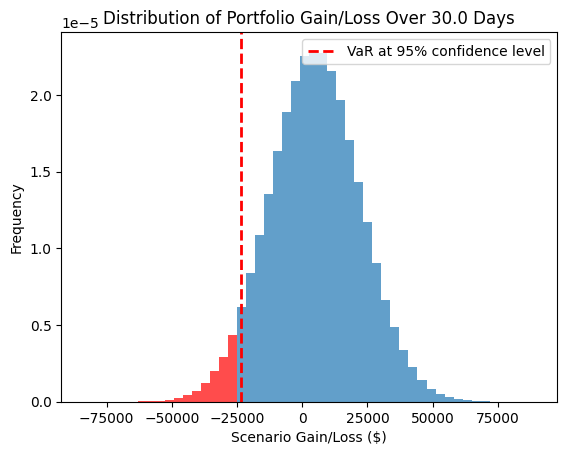

In [15]:

n, bins, patches = plt.hist(scenarioReturn, bins=50, density=True, alpha=0.7)

plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')


for i in range(len(bins)-1):
    if bins[i+1] < -VaR:
        patches[i].set_facecolor('red')

plt.legend()
plt.savefig('var_hist.png')
plt.show()



In [16]:
book = xw.Book('Richspread.xlsx')
portfolio = book.sheets['Portfolio']
confidence_pct = int(confidence_interval * 100)
statement = f"There is a {confidence_pct}% confidence that the portfolio will not lose more than ${VaR:,.2f} over {days} days."


print(statement)


portfolio.range('A24').value = statement
portfolio.pictures.add('var_hist.png', name='VaR_Hist', update=True, left=portfolio.range('A25').left, top=portfolio.range('A25').top)


There is a 95% confidence that the portfolio will not lose more than $23,525.79 over 30.0 days.


<Picture 'VaR_Hist' in <Sheet [Richspread.xlsx]Portfolio>>

In [20]:
# Calculate Expected Shortfall (ES)
losses = np.array(scenarioReturn)
threshold = np.percentile(losses, 100*(1-confidence_interval))
expected_shortfall = -losses[losses <= threshold].mean()
print(f"Expected Shortfall (ES) at {confidence_interval*100}% confidence level: ${expected_shortfall:.2f}")

es_statement = f"The Expected Shortfall at {confidence_interval*100}% confidence level is ${expected_shortfall:,.2f}."
print(es_statement)

portfolio.range('A49').value = es_statement

Expected Shortfall (ES) at 95.0% confidence level: $30782.70
The Expected Shortfall at 95.0% confidence level is $30,782.70.
